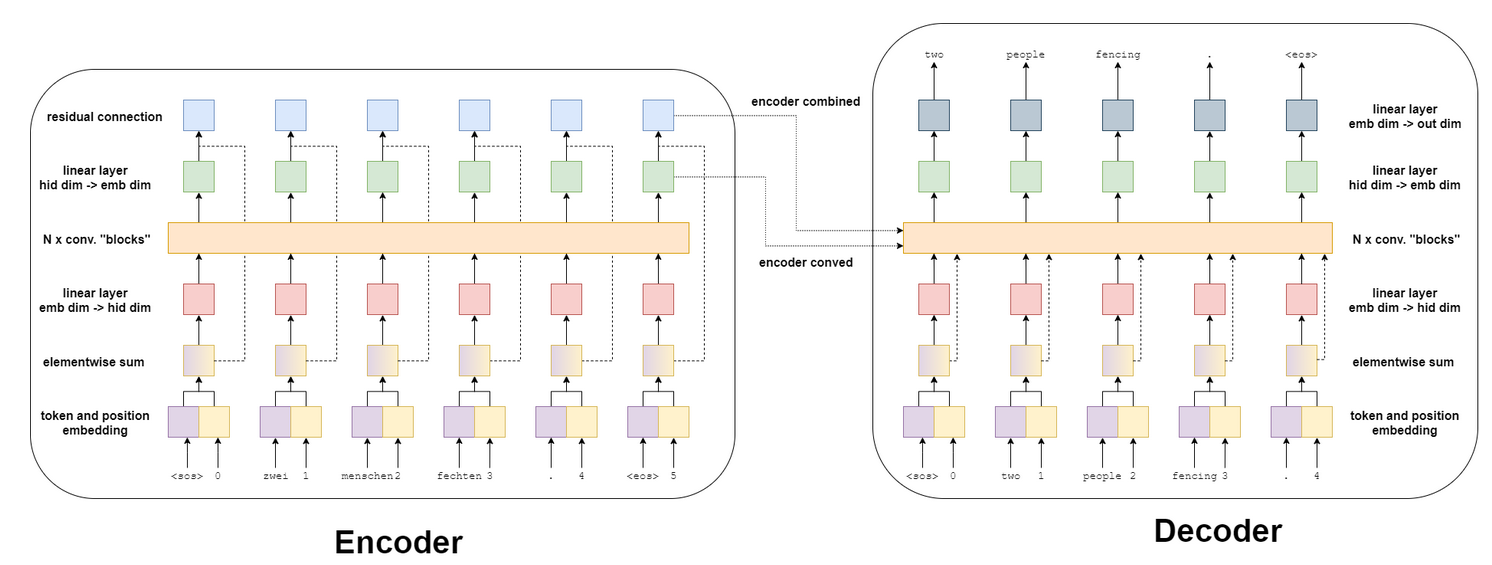

In [1]:
from IPython.display import Image
Image("../input/idln-temp-files-version-1/ConvSe2SeqArchitecture.png") 

## Idea
My idea is to predict the local waypoint trajectors (starting at origin) using features from IMU sensor alone. The feature generation itself can be found at this [notebook](https://www.kaggle.com/suryajrrafl/interpolated-imu-data). The model consists of encoder-decoder architecture using Convolution blocks with attention mechanism.

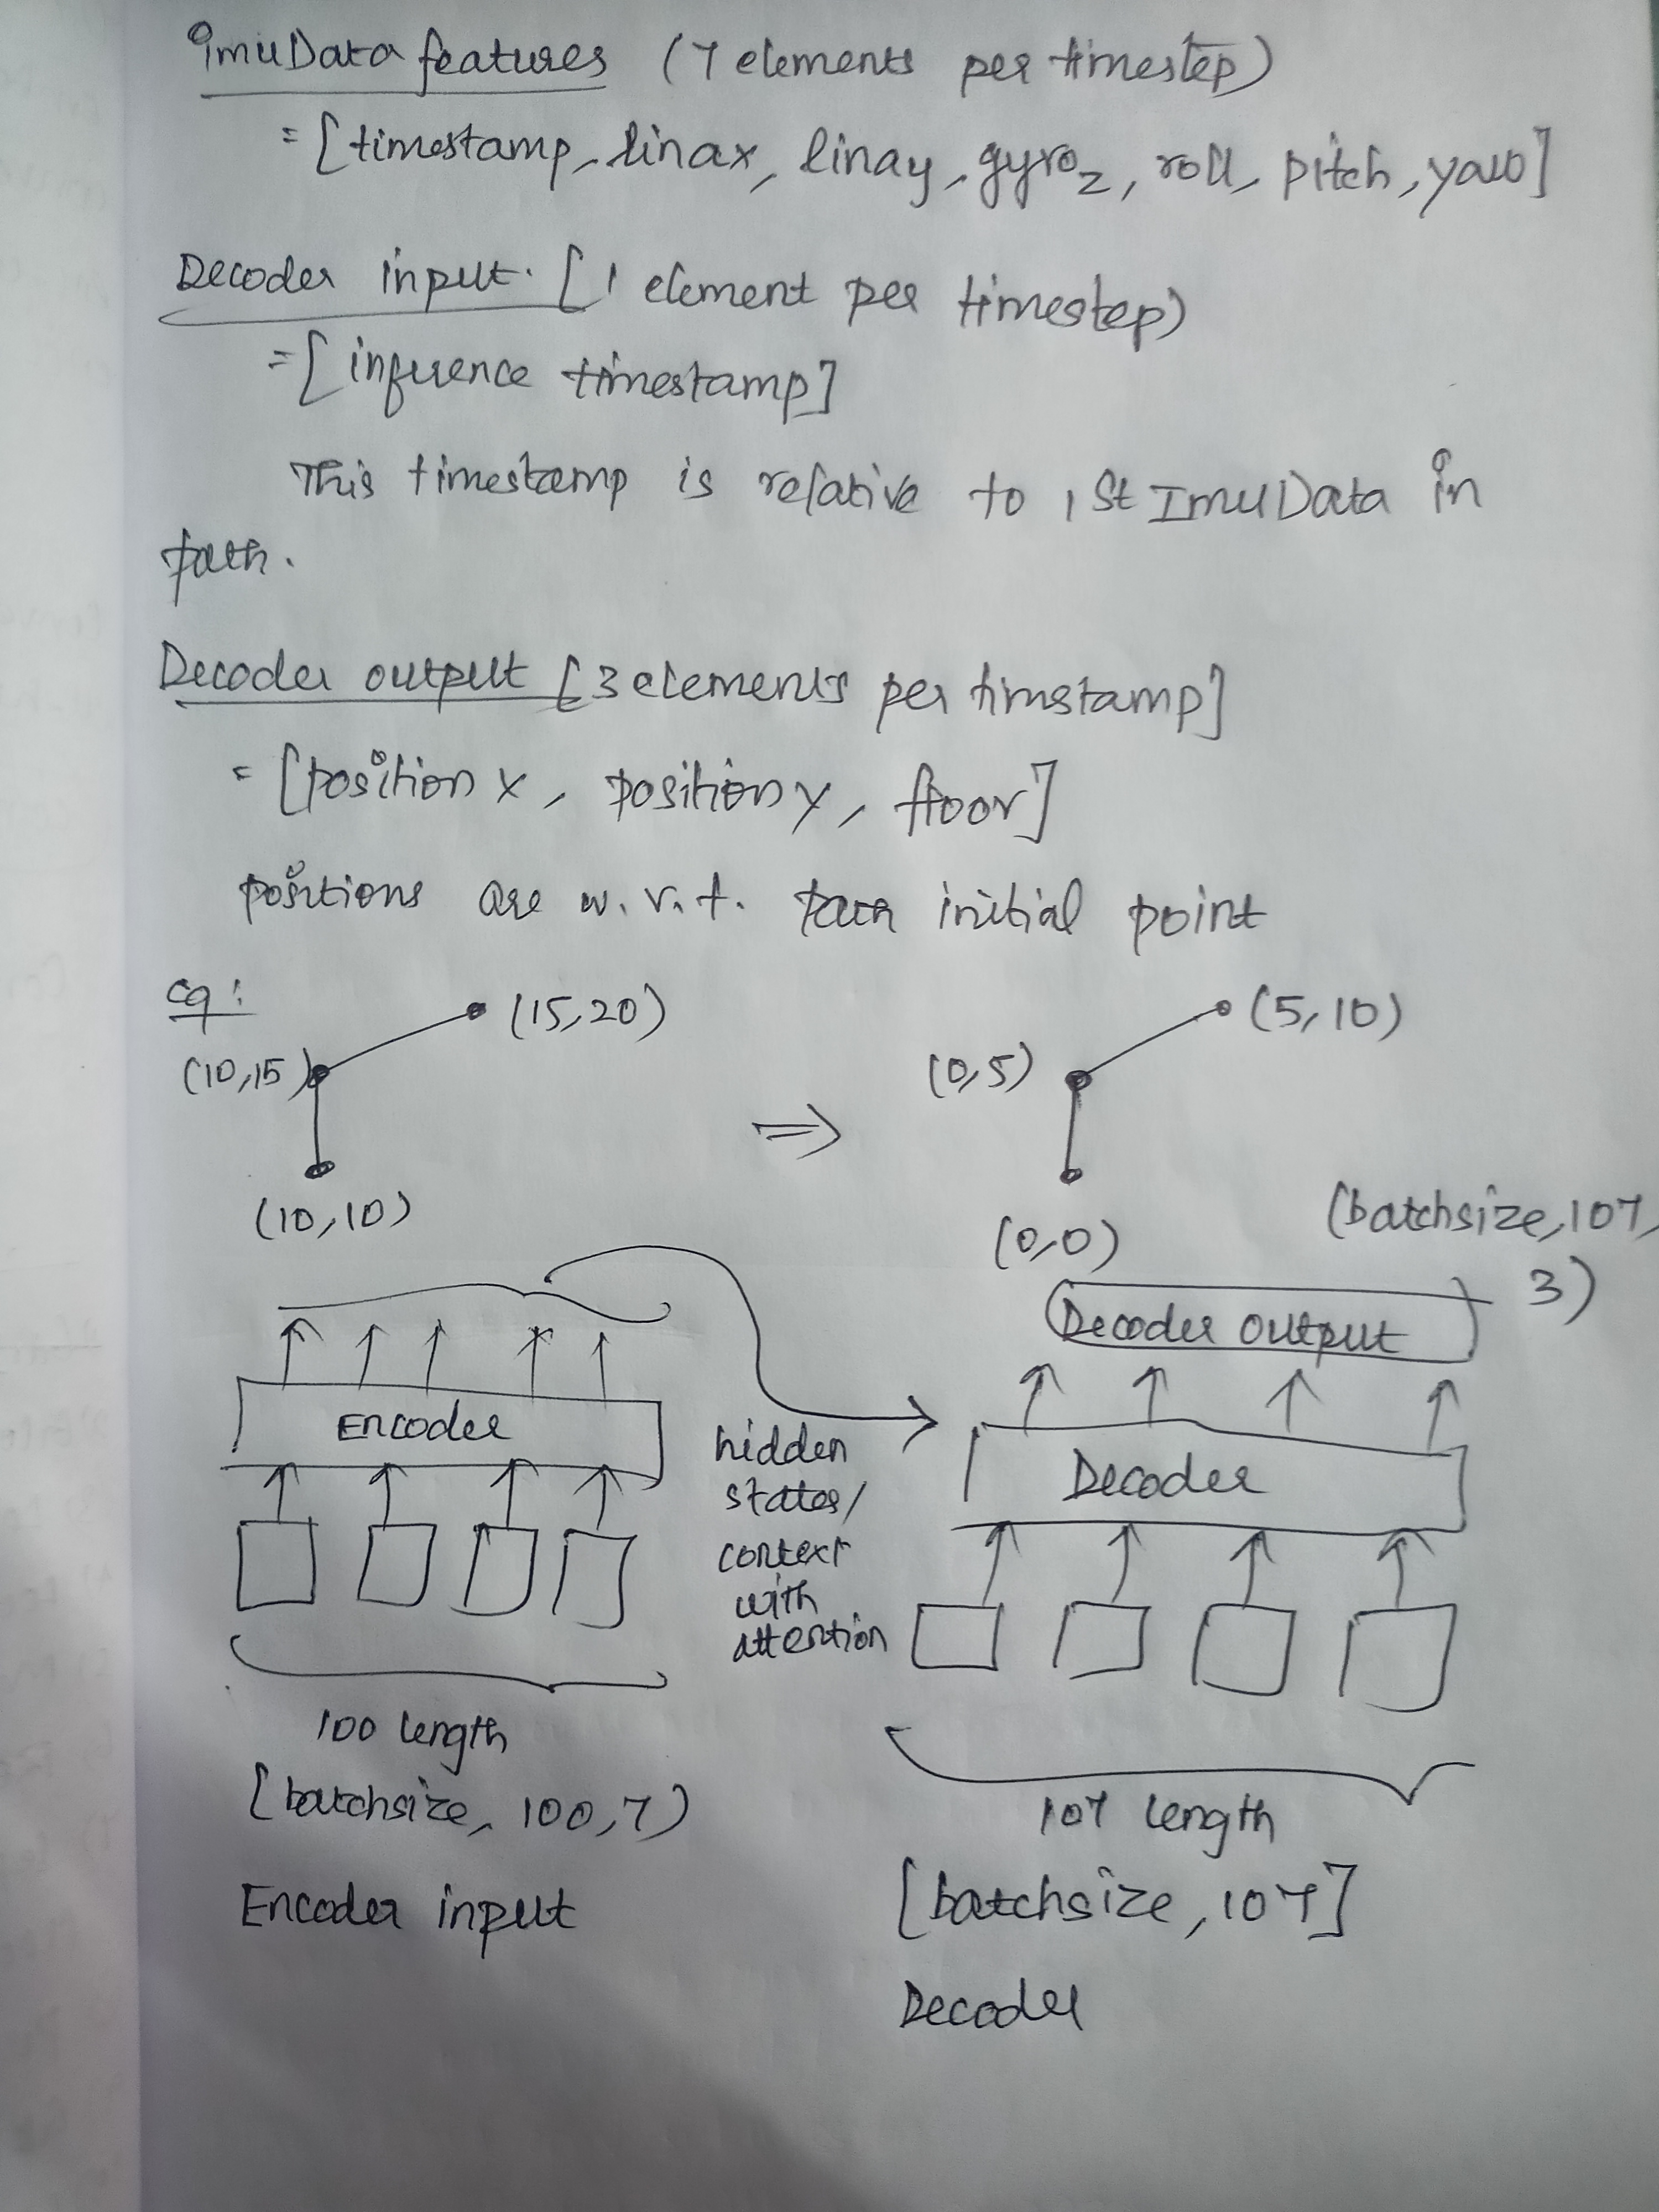

In [2]:
Image("../input/idln-temp-files-version-1/convSe2SeqModelIdea.jpg") 



1. Encoder input - Features are IMU data, considering 2D plane, (i.e), timestamps of IMU data, linear acceleration in x,y directions and yaw rate (gyroscope z axis) along with euler angles w.r.t magnetic north. 

2. Decoder input - Timestamp at which waypoint is to be inferred. The inference time is relative to the first imu timestamp.

3. Decoder output - Local waypoints (i.e) actual waypoint - first waypoint of path. The points are translated such that first waypoint is the origin. This is done because, the imu features give local trajectory (~shape of the path) but by itself cannot infer global trajectory directly. 

The encoder and decoder data are made of fixed length. For encoder, the imu data is sampled to be of 100 time sequences. For decoder, the maximum waypoints is fixed at 107 (max number of waypoints in path in train data). More details on data generation can be found at notebook above. Padding is done to ensure equal length in all batches. 


## Problem
Due to some issue, the model doesn't seem to learn anything. The loss seems to reduce 0.0x only with each epoch. I have doubts in loss computation (**competitionMetric_Seq2Seq**). I am not sure if the current implementation is the correct way to calculate loss for padded elements. But this is only guess and I am not sure where the mistake is. If somebody can help me out, it would be great.

## References
Most of the the model implementation is from the wonderful series of notebooks found at the following repo. I just tried adapting the notebook to our problem statement. 

1. [seq2seq modelling pytorch](https://github.com/bentrevett/pytorch-seq2seq)
2. [Pytorch LSTM references](https://www.youtube.com/watch?v=sQUqQddQtB4)
3. [Variable-length batches](https://towardsdatascience.com/taming-lstms-variable-sized-mini-batches-and-why-pytorch-is-good-for-your-health-61d35642972e)
    

## Library imports

In [3]:
!pip install pickle5

     |████████████████████████████████| 256 kB 12.5 MB/s eta 0:00:01


In [4]:
## !pip install torch-summary
## from torchsummary import summary

In [5]:
# basic imports
import os
import gc
import math
import glob
import random
import itertools
import numpy as np
import pandas as pd
import pickle5 as pickle
## from tqdm.notebook import tqdm
from tqdm import tqdm

# DL library imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
## from  torch.cuda.amp import autocast, GradScaler

# metrics calculation
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold

# basic plotting library
import matplotlib.pyplot as plt
import seaborn as sns

# interactive plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

import warnings  
warnings.filterwarnings('ignore')

## Config parameters

In [6]:
class CFG:
    # pipeline parameters
    SEED        = 42
    TRAIN       = True
    LR_FIND     = False
    TEST        = False
    N_FOLDS     = 5 #交叉验证 折数
    N_EPOCHS    = 50 #训练历元数
    TEST_BATCH_SIZE  = 128
    TRAIN_BATCH_SIZE = 16
    NUM_WORKERS      = 4 #dataloader时候的并行度
    DATA_FRAC        = 1.0
    FOLD_TO_TRAIN    = [0,1,2,3,4] # 

    # model parameters
    MODEL_ARCH  = 'seq2seq'
    MODEL_NAME  = 'ConvSeq_v1'
    WGT_PATH    = ''
    WGT_MODEL   = ''
    PRINT_N_EPOCH = 2
    RNN_TYPE = 'LSTM'
    
    # scheduler variables
    MAX_LR    = 3e-3
    MIN_LR    = 1e-6
    SCHEDULER = 'CosineAnnealingWarmRestarts'  # ['ReduceLROnPlateau', 'None', 'OneCycleLR','CosineAnnealingLR']
    T_0       = 10      # CosineAnnealingWarmRestarts
    T_MULT    = 1       # CosineAnnealingWarmRestarts
    T_MAX     = 10      # CosineAnnealingLR

    # optimizer variables
    OPTIMIZER     = 'Adam'
    WEIGHT_DECAY  = 1e-6
    GRD_ACC_STEPS = 1
    MAX_GRD_NORM  = 1

    BUILDING_SITES_RANGE = [0,24]

MODEL_INIT_WEIGHT = 0.08
INPUT_DIM = 7
DECODER_INPUT_DIM = 1
OUTPUT_DIM = 2
ENC_EMB_DIM = 16
DEC_EMB_DIM = 16
HID_DIM = 32
N_LAYERS = 10
KERNEL_SIZE = 3
FILLER_VALUE = 0.0
ENC_DROPOUT = 0.25
DEC_DROPOUT = 0.25   

In [7]:
floor_map = {"B2": -2, "B1": -1, "F1": 0, "F2": 1, "F3": 2, "F4": 3, "F5": 4, "F6": 5, "F7": 6, "F8": 7, "F9": 8,
             "1F": 0, "2F": 1, "3F": 2, "4F": 3, "5F": 4, "6F": 5, "7F": 6, "8F": 7, "9F": 8}

modelOutputDir = '.'
imuFeatures_trainPath = '../input/idln-mlp-wifi-features-dataset/imuSeq2SeqDataLocal_train.pickle'
## imuFeatures_testPath  = ''
sampleCsvPath = '../input/indoor-location-navigation/sample_submission.csv'
ssubm = pd.read_csv(sampleCsvPath)
ssubm_df = ssubm["site_path_timestamp"].apply(lambda x: pd.Series(x.split("_")))

## number of time sequences to give as input to encoder
imuInputSequenceLength = 100

## max number of time sequences in decoder
wayPointMaxSequenceLength = 107

## Helper functions

In [8]:
def getBuildingName(buildingDataPath):
    return buildingDataPath.split('/')[-1].split('_')[0]

In [9]:
def find_no_of_trainable_params(model):
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_trainable_params

In [10]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(CFG.SEED)

In [11]:
def getSeq2SeqFeatures(imuDataPath):
    """ """
    # read features from file 
    with open(imuDataPath, 'rb') as inputFile:
        imuData = pickle.load(inputFile)        
    return imuData

In [12]:
def competitionMetric_Seq2Seq(preds, targets, wayPointsMask):
    """ custom metric for seq2seq models """
    ## reshape predicitons and targets to 2D vector
    #preds.shape 为【16，107，2】
    outputSize = preds.shape[-1]
    preds      = preds.view(-1, outputSize)#维度【16*107，2】
    targets    = targets[:,:, 0:outputSize]
    targets    = targets.view(-1, outputSize)#维度【16*107，2】
    
    ## unroll into 1D vector
    wayPointsMask = wayPointsMask.view(-1)
    totalWayPoints = wayPointsMask.sum()    
        
    ## mask predictions
    xPredictions = preds[:,0] * wayPointsMask
    yPredictions = preds[:,1] * wayPointsMask
    x_true=targets[:,0]
    y_true=targets[:,1]
    ## position error
    #meanPosPredictionError = torch.sqrt(torch.square(xPredictions -  targets[:,0]) + torch.square(yPredictions -  targets[:,1]) + 1e-6).sum()
    meanPosPredictionError = torch.sqrt(torch.square(xPredictions -  x_true) + torch.square(yPredictions -  y_true) + 1e-6).sum()
    meanPosPredictionError = meanPosPredictionError / totalWayPoints
    
    """
    ## floor prediction error
    floorPredictions = preds[:,2] * wayPointsMask
    if((preds.shape[1] == 3) and (targets.shape[1] ==3)):
        meanFloorPredictionError = (15 * (torch.abs(floorPredictions - targets[:,2]))).sum()
        meanFloorPredictionError = meanFloorPredictionError / totalWayPoints
    else:
        meanFloorPredictionError = 0.0
    """
    meanFloorPredictionError = torch.tensor(0.0).to(device)
    return meanPosPredictionError, meanFloorPredictionError

In [13]:
# def competitionMetric(preds, targets,wayPointsMask): 
#     """ The metric used in this competition """ 
#     #position error 
#     print(preds.shape,targets.shape)
#     meanPosPredictionError = torch.mean(torch.sqrt( torch.pow((preds[:,0] - targets[:,0]), 2) + torch.pow((preds[:,1] - targets[:,1]), 2)))
#     ## floor prediction error
#     if((preds.shape[2] == 3) and (targets.shape[2] ==3)):
#         meanFloorPredictionError = torch.mean(15 * torch.abs(preds[:,2] - targets[:,2]))
#     else:
#         meanFloorPredictionError = 0.0
#     return meanPosPredictionError, meanFloorPredictionError

In [14]:
def getOptimizer(model : nn.Module):    
    if CFG.OPTIMIZER == 'Adam':
        #动量（Momentum）：通过累积过去梯度的方向，帮助模型更快地收敛，并减少震荡。自适应学习率（Adaptive Learning Rate）：为每个参数单独调整学习率，基于梯度的一阶矩（均值）和二阶矩（未中心化的方差）。
        optimizer = optim.Adam(model.parameters(), weight_decay=CFG.WEIGHT_DECAY, lr=CFG.MAX_LR)
    else:
        optimizer = optim.SGD(model.parameters(), weight_decay=CFG.WEIGHT_DECAY, lr=CFG.MAX_LR, momentum=0.9)
    return optimizer

In [15]:
#为optimizer 设定学习率
#OneCycleLR：一种周期性学习率调度器。
#CosineAnnealingWarmRestarts：基于余弦退火的学习率调度器，支持重启机制。
#CosineAnnealingLR：基于余弦退火的学习率调度器。

def getScheduler(optimizer, dataloader_train):
    if CFG.SCHEDULER == 'OneCycleLR':
        scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr= CFG.MAX_LR, epochs = CFG.N_EPOCHS, 
                          steps_per_epoch = len(dataloader_train), pct_start=0.25, div_factor=10, anneal_strategy='cos')
    elif CFG.SCHEDULER == 'CosineAnnealingWarmRestarts':
        scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=CFG.T_MULT, eta_min=CFG.MIN_LR, last_epoch=-1)
    elif CFG.SCHEDULER == 'CosineAnnealingLR':
        scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_MAX * len(dataloader_train), eta_min=CFG.MIN_LR, last_epoch=-1)
    else:
        scheduler = None
    return scheduler

In [16]:
#权重初始化
def initModelWeights(model):
    for name, param in model.named_parameters():
        nn.init.uniform_(param.data, -MODEL_INIT_WEIGHT, MODEL_INIT_WEIGHT)

In [17]:
def getDataLoader(dataset, datasetType : str):
    if datasetType == 'train':
        batchSize = CFG.TRAIN_BATCH_SIZE
        shuffleDataset = True
    else:
        batchSize = CFG.TEST_BATCH_SIZE
        shuffleDataset = False
    
    dataLoader = DataLoader(dataset, batch_size= batchSize, shuffle=shuffleDataset,
                            num_workers=CFG.NUM_WORKERS, pin_memory=False, drop_last=False)
    return dataLoader

In [18]:
def plotTrainingResults(resultsDf, buildingName):
    # subplot to plot
    fig = make_subplots(rows=1, cols=1)
    colors = [ ('#d32f2f', '#ef5350'), ('#303f9f', '#5c6bc0'), ('#00796b', '#26a69a'),
                ('#fbc02d', '#ffeb3b'), ('#5d4037', '#8d6e63')]

    # find number of folds input df
    numberOfFolds = resultsDf['fold'].nunique()
    
    # iterate through folds and plot
    for i in range(numberOfFolds):
        data = resultsDf[resultsDf['fold'] == i]
        fig.add_trace(go.Scatter(x=data['epoch'].values, y=data['trainPosLoss'].values,
                                mode='lines', visible='legendonly' if i > 0 else True,
                                line=dict(color=colors[i][0], width=2),
                                name='{}-trainPossLoss-Fold{}'.format(buildingName, i)),row=1, col=1)

        fig.add_trace(go.Scatter(x=data['epoch'], y=data['valPosLoss'].values,
                                 mode='lines+markers', visible='legendonly' if i > 0 else True,
                                 line=dict(color=colors[i][1], width=2),
                                 name='{}-valPosLoss-Fold{}'.format(buildingName,i)),row=1, col=1)
    fig.show()

## Dataset class

In [19]:
class imuFeaturesDataset_train(Dataset):
    def __init__(self, imuData):
        self.imuData = imuData 
        
    def __getitem__(self, index):
        ## output shape is (imuInputSequenceLength, 7)
        ## where 7 indicates numbre of features - [delta_ts, lin_ax, lin_ay, gz, roll, pitch, yaw]
        ## imuInputSequenceLength is max input sequence length
        #encoder中为插值后的imu数据
        encoderData  = self.imuData['encoderData'][index].transpose()
        encoderData  = torch.from_numpy(encoderData)
        encoderData[:,0]   = encoderData[:,0]   / 100.0
        encoderData[:,1:3] = encoderData[:,1:3] / 10.0
        encoderData[:,3]   = encoderData[:,3]   / 5.0
        encoderData[:,4:]  = encoderData[:,4:]  / 6.28

        ## output shape is (wayPointMaxSequenceLength, 3)
        ## where 3 indicates numbere of targets - [x,y,floor]
        #decoder 中为位置（相对第一个点的偏移） 和楼层
        decoderData  = self.imuData['decoderData'][index]  ## .transpose()
        decoderData  = torch.from_numpy(decoderData)

        ## output shape is (1, wayPointMaxSequenceLength)
        ## where 1 indicates inference Ts - decoder input
        #相对第一个点的时间增量
        inferenceTs  = self.imuData['inferenceTsList'][index]
        inferenceTs  = torch.from_numpy(inferenceTs)
        inferenceTs  = inferenceTs  / 100.0
        
        ## path name
        pathName = self.imuData['path'][index]
        
        ## output shape is (1, wayPointMaxSequenceLength)
        #mask 机制，
        wayPointsMask = self.imuData['wayPointMask'][index]
        wayPointsMask  = torch.from_numpy(wayPointsMask)

        
        #encoderData, encoder的输入 维度(imuInputSequenceLength, 7)  where 7 indicates numbre of features - [delta_ts, lin_ax, lin_ay, gz, roll, pitch, yaw] 输入encoder的是imu数据
        #inferenceTs, decoder的输入 维度 (1, wayPointMaxSequenceLength) 即输入decoder是时间增量
        #decoderData, decoder的输出 维度 (wayPointMaxSequenceLength, 3) 即预测位置和楼层
        #pathName, 轨迹id
        #wayPointsMask 掩码
        return encoderData, inferenceTs, decoderData, pathName, wayPointsMask
     
    def __len__ (self):
        return len(self.imuData)

## Convolution seq2seq Model classes - Encoder, Decoder and Seq2Seq

In [20]:
class Encoder(nn.Module):
    def __init__(self, inputSize, embSize, hidSize, nLayers, \
                 kernelSize, dropout, device, maxSeqLen = 100):
        
        super().__init__()
        assert kernelSize % 2 == 1, "Kernel size must be odd!"#卷积大小为奇数1、 卷积核中心对齐。2、为了保持卷积操作后输出的尺寸与输入一致，通常需要对输入进行填充（padding）。奇数大小的卷积核可以实现对称填充，而偶数大小的卷积核会导致不对称填充。
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        ## store variables
        self.encFeatSize = inputSize#输入特征维度
        self.encEmbSize  = embSize#输入特征 embedding 维度
        self.encHidSize  = hidSize#隐层维度
        self.nLayers     = nLayers#卷积层数
        self.kernelSize  = kernelSize#卷积核大小
        self.device      = device
        self.encSeqLen   = maxSeqLen#输入特征序列长度
        
        ## encoder layers
        self.tokEmbedding = nn.Linear(self.encFeatSize, self.encEmbSize)#输入特征用全连接进行embedding
        self.posEmbedding = nn.Embedding(self.encSeqLen, self.encEmbSize)#位置embedding
        self.emb2hid = nn.Linear(self.encEmbSize, self.encHidSize)
        self.hid2emb = nn.Linear(self.encHidSize, self.encEmbSize)
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = self.encHidSize, out_channels = 2 * self.encHidSize, \
                                    kernel_size = self.kernelSize,  padding = (self.kernelSize - 1) // 2)
                                    for _ in range(self.nLayers)])#多个卷积层串联
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        ## src = [batchSize, encSeqLen, encFeatSize]
        batchSize = src.shape[0]
        
        ## 1. create position tensor
        ## pos = [0, 1, 2, 3, ..., encSeqLen - 1], repeated for batchSize, along rows
        ## pos = [batchSize, encSeqLen]
        pos = torch.arange(0, self.encSeqLen).unsqueeze(0).repeat(batchSize, 1).to(self.device)
              
        ## 2. embed tokens and positions
        ## tokEmbedded = posEmbedded = [batchSize, encSeqLen, encEmbSize]        
        tokEmbedded = self.tokEmbedding(src)
        posEmbedded = self.posEmbedding(pos)
        
        ## 3. combine embeddings by elementwise summing
        ## embedded = [batchSize, encSeqLen, encEmbSize]
        embedded = self.dropout(tokEmbedded + posEmbedded)
        
        ## 4. pass embedded through linear layer to convert from emb dim to hid dim
        ## convInput = [batchSize, encSeqLen, encHidSize]
        convInput = self.emb2hid(embedded)
        
        ## 5. permute for convolutional layer
        ## convInput = [batchSize, encHidSize, encSeqLen]
        convInput = convInput.permute(0, 2, 1) 
        
        ## 6. begin convolutional blocks..., repeate for nLayers
        for i, conv in enumerate(self.convs):
        
            ## 7. pass through convolutional layer
            ## conved = [batchSize, 2*encHidSize, encSeqLen]
                #数据的维度为convInput = [batchSize, encHidSize, encSeqLen]   一维卷积nn.Conv1d(in_channels = self.encHidSize 那么就是对输入序列的相邻时刻的所有特征进行卷积。  Output Length = (encSeqLen + 2 * Padding - Kernel Size) / Stride + 1，其中stride 默认1 
            conved = conv(self.dropout(convInput))

            ## 8. pass through GLU activation function
            ## conved = [batchSize, encHidSize, encSeqLen]
            conved = F.glu(conved, dim = 1)

            ## 9. apply residual connection
            ## conved = [batchSize, encHidSize, encSeqLen]
            conved = (conved + convInput) * self.scale

            ## 10. set convInput to conved for next loop iteration
            convInput = conved
        
        ## ...end convolutional blocks
        
        ## 11. permute and convert back to emb dim
        ## conved = [batchSize, encSeqLen, encEmbSize]
        conved = self.hid2emb(conved.permute(0, 2, 1))
        
        ## 12. elementwise sum output (conved) and input (embedded) to be used for attention
        ## combined = [batchSize, encSeqLen, encEmbSize]
        combined = (conved + embedded) * self.scale
        return conved, combined #encoder 的输出一个是卷积的原始输出conved ，一个是conved +卷积的输入embedded 相当于残差网络 

In [21]:
class Decoder(nn.Module):
    def __init__(self, inputSize, embSize, hidSize, outputSize, nLayers, \
                 kernelSize, dropout, fillerValue, device, maxSeqLen = 107):
        
        super().__init__()
        self.scale = torch.sqrt(torch.FloatTensor([0.5])).to(device)
        
        ## store vairables
        self.decFeatSize = inputSize
        self.decEmbSize  = embSize
        self.decHidSize  = hidSize
        self.decOutSize  = outputSize        
        self.nLayers     = nLayers
        self.kernelSize  = kernelSize
        self.fillerValue = fillerValue
        self.device      = device        
        self.decSeqLen   = maxSeqLen
        
        
        ## decoder layers
        self.tokEmbedding = nn.Linear(self.decFeatSize, self.decEmbSize)#decFeatSize 为1，decEmbSize=16 为embedding 维度 保持和encoder一致
        self.posEmbedding = nn.Embedding(self.decSeqLen, self.decEmbSize)
        self.emb2hid = nn.Linear(self.decEmbSize, self.decHidSize)
        self.hid2emb = nn.Linear(self.decHidSize, self.decEmbSize)
        
        ## attention specific layers
        self.attnHid2emb = nn.Linear(self.decHidSize, self.decEmbSize)
        self.attnEmb2hid = nn.Linear(self.decEmbSize, self.decHidSize)
        self.fcOut = nn.Linear(self.decEmbSize, self.decOutSize)

        ## convolution block layers
        self.convs = nn.ModuleList([nn.Conv1d(in_channels = self.decHidSize, out_channels = 2 * self.decHidSize, \
                                    kernel_size = self.kernelSize) for _ in range(self.nLayers)])
        self.dropout = nn.Dropout(dropout)

      
    def calculateAttention(self, embedded, conved, encoderConved, encoderCombined):
        
        ## embedded = [batchSize, decSeqLen, decEmbSize]#卷积前的输入
        ## conved = [batchSize, decHidSize, decSeqLen]#卷积后的结果
        ## encoderConved = encoderCombined = [batchSize, encSeqLen, decEmbSize]##encoderConved encoder的卷积的结果，encoderCombined encoder的卷积的结果+卷积输入（残差链接）
        
        ## a. permute and convert back to emb dim
        ## convedEmb = [batchSize, decSeqLen, decEmbSize]
        convedEmb = self.attnHid2emb(conved.permute(0, 2, 1))
        
        ## b. residual connection。残差链接
        ## combined = [batchSize, decSeqLen, decEmbSize]
        combined = (convedEmb + embedded) * self.scale
        
        ## c. Energy matrix calculation 
        ## energy = [batchSize, decSeqLen, encSeqLen]
        #获得了 decoder的输入序列 和 encoder 的输入序列 之间的attetion score
        energy = torch.matmul(combined, encoderConved.permute(0, 2, 1))
        
        ## d. attention is softmax of energy
        ## attention = [batchSize, decSeqLen, encSeqLen]
        attention = F.softmax(energy, dim=2)
        
        ## e. attention over encoded states 
        ## attendedEncoding = [batchSize, decSeqLen, decEmbSize]
        #根据attetion score 用encoder 的输入序列组装 decoder 输入序列的每一个词
        attendedEncoding = torch.matmul(attention, encoderCombined)
        
        ## f. convert from emb dim -> hid dim
        ## attendedEncoding = [batchSize, decSeqLen, decHidSize]
        attendedEncoding = self.attnEmb2hid(attendedEncoding)
        
        ## g. apply residual connection with decoder token 
        ## attendedCombined = [batch size, decHidSize, decSeqLen]
        attendedCombined = (conved + attendedEncoding.permute(0, 2, 1)) * self.scale
        return attention, attendedCombined
        
    
    def forward(self, trg, encoderConved, encoderCombined):
        ## trg = [batchSize, decSeqLen] decoder的输入是时间增量
        ## encoderConved = encoderCombined = [batchSize, encSeqLen, decEmbSize]
        batchSize = trg.shape[0]
            
        ## 1. create position tensor
        ## pos = [0, 1, 2, 3, ..., decSeqLen - 1], repeated for batchSize, along rows
        ## pos = [batchSize, decSeqLen]        
        pos = torch.arange(0, self.decSeqLen).unsqueeze(0).repeat(batchSize, 1).to(self.device)
        
        ## 2. embed tokens and positions
        ## tokEmbedded = posEmbedded = [batchSize, decSeqLen, decEmbSize] 
        trg = trg.unsqueeze(2) #维度 [batchSize, decSeqLen，1] 
        tokEmbedded = self.tokEmbedding(trg)
        posEmbedded = self.posEmbedding(pos)
        
        ## 3. combine embeddings by elementwise summing
        ## embedded = [batchSize, decSeqLen, decEmbSize]
        embedded = self.dropout(tokEmbedded + posEmbedded)
        
        ## 4. pass embedded through linear layer to convert from emb dim to hid dim
        ## convInput = [batchSize, decSeqLen, decHidSize]
        convInput = self.emb2hid(embedded)
        
        ## 5. permute for convolutional layer
        ## convInput = [batchSize, decHidSize, decSeqLen]
        convInput = convInput.permute(0, 2, 1)         
        padding = torch.zeros(batchSize, self.decHidSize, self.kernelSize - 1).fill_(\
                       self.fillerValue).to(self.device) 
        
        ## 6. begin of convolution blocks 
        for i, conv in enumerate(self.convs):
        
            ## 7. apply dropout
            convInput = self.dropout(convInput)
        
            ## 8. need to pad so decoder can't "cheat"
            ## paddedConvInput = [batchSize, decHidSize, decSeqLen + kernelSize - 1]
            #在输入序列前增加padding 原理解释见https://zhuanlan.zhihu.com/p/1888126239514010061
            paddedConvInput = torch.cat((padding, convInput), dim = 2)
        
            ## 9. pass through convolutional layer
            ## conved = [batchSize, 2 * decHidSize, decSeqLen]
            conved = conv(paddedConvInput)

            ## 10. pass through GLU activation function
            ## conved = [batchSize, decHidSize, decSeqLen]
            conved = F.glu(conved, dim = 1)

            ## 11. calculate attention
            ## attention = [batchSize, decSeqLen, encSeqLen]
            ## conved = [batch size, decHidSize, decSeqLen]
            attention, conved = self.calculateAttention(embedded, conved, 
                                encoderConved, encoderCombined)
            
            ## 12. apply residual connection
            ## conved = [batchSize, decHidSize, decSeqLen]
            conved = (conved + convInput) * self.scale
                        
            ## 13. set convInput to conved for next loop iteration
            convInput = conved
            
        ## 14. convert to decEmbSize
        #conved = [batchSize, decSeqLen, decEmbSize]
        conved = self.hid2emb(conved.permute(0, 2, 1))
         
        ## 15. linear layer to output dimension
        ## output = [batchSize, decSeqLen, decOutSize]
        output = self.fcOut(self.dropout(conved))
        return output, attention

In [22]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg):
        ## src = [batchSize, encSeqLen, encFeatSize]
        ## trg = [batchSize, decSeqLen]
        
        ## 1. calculate z^u (encoderConved) and (z^u + e) (encoderCombined)
        ## encoderConved is output from final encoder conv. block
        ## encoderCombined = encoderConved + src embedding + positional embeddings (all elementwise)
        ## encoderConved = encoderCombined = [batchSize, encSeqLen, decEmbSize]
        encoderConved, encoderCombined = self.encoder(src)
                    
        ## 2. calculate predictions of next words
        ## output is a batch of predictions for each input in the decoder
        ## attention a batch of attention scores across the encoder sequence for 
        ## each timestamp in the decoder
        ## output = [batchSize, decSeqLen, decOutSize]
        ## attention = [batchSize, decSeqLen, encSeqLen]
        output, attention = self.decoder(trg, encoderConved, encoderCombined)        
        return output, attention

## Lr range finder

In [23]:
def plot_lr_finder_results(lr_finder): 
    # Create subplot grid
    fig = make_subplots(rows=1, cols=2)
    # layout ={'title': 'Lr_finder_result'}
    
    # Create a line (trace) for the lr vs loss, gradient of loss
    trace0 = go.Scatter(x=lr_finder['log_lr'], y=lr_finder['smooth_loss'],name='log_lr vs smooth_loss')
    trace1 = go.Scatter(x=lr_finder['log_lr'], y=lr_finder['grad_loss'],name='log_lr vs loss gradient')

    # Add subplot trace & assign to each grid
    fig.add_trace(trace0, row=1, col=1);
    fig.add_trace(trace1, row=1, col=2);
    iplot(fig, show_link=False)
    #fig.write_html(CFG.MODEL_NAME + '_lr_find.html');

In [24]:
def find_lr(model, data_loader, optimizer, criterion, init_value = 1e-8, final_value=100.0, beta = 0.98, num_batches = 200):
    assert(num_batches > 0)
    mult = (final_value / init_value) ** (1/num_batches)
    lr = init_value
    optimizer.param_groups[0]['lr'] = lr
    batch_num = 0
    avg_loss = 0.0
    best_loss = 0.0
    smooth_losses = []
    raw_losses = []
    log_lrs = []
    dataloader_it = iter(data_loader)
    progress_bar = tqdm(range(num_batches))                
        
    for idx in progress_bar:
        batch_num += 1
        try:
            encoderInput, decoderInput, decoderOutput, _, wayPointsMask = next(dataloader_it)
            ## print(encoderInput.shape, decoderInput.shape)
        except:
            dataloader_it = iter(data_loader)
            encoderInput, decoderInput, decoderOutput, _, wayPointsMask = next(dataloader_it)

        # Move input and label tensors to the default device
        encoderInput = encoderInput.to(device)
        decoderInput = decoderInput.to(device)
        decoderOutput = decoderOutput.to(device)

        # handle exception in criterion
        try:
            # Forward pass
            preds, _ = model(encoderInput, decoderInput)
            posLoss, floorLoss = criterion(preds, decoderOutput, wayPointsMask)
            loss = posLoss + floorLoss
        except:
            if len(smooth_losses) > 1:
                grad_loss = np.gradient(smooth_losses)
            else:
                grad_loss = 0.0
            lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                                 'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
            return lr_finder_results 
                    
        #Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) *loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)
        
        #Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 50 * best_loss:
            if len(smooth_losses) > 1:
                grad_loss = np.gradient(smooth_losses)
            else:
                grad_loss = 0.0
            lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                                 'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
            return lr_finder_results
        
        #Record the best loss
        if smoothed_loss < best_loss or batch_num==1:
            best_loss = smoothed_loss
        
        #Store the values
        raw_losses.append(loss.item())
        smooth_losses.append(smoothed_loss)
        log_lrs.append(math.log10(lr))
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.MAX_GRD_NORM)
        optimizer.step()
        
        # print info
        progress_bar.set_description(f"loss:{loss.item()},smoothLoss: {smoothed_loss},lr:{lr}")

        #Update the lr for the next step
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr
    
    grad_loss = np.gradient(smooth_losses)
    lr_finder_results = {'log_lr':log_lrs, 'raw_loss':raw_losses, 
                         'smooth_loss':smooth_losses, 'grad_loss': grad_loss}
    return lr_finder_results

In [25]:
if CFG.LR_FIND == True:
    # create dataset, dataloader instance
    data = getSeq2SeqFeatures(imuFeatures_trainPath)
    tempTrainDataset = imuFeaturesDataset_train(data)
    tempTrainDataloader = getDataLoader(tempTrainDataset, datasetType='train')

    ## Device as cpu or tpu
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')
    print(device)

    # create model instance   
    enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, KERNEL_SIZE, \
                  ENC_DROPOUT, device, imuInputSequenceLength).double()
    dec = Decoder(DECODER_INPUT_DIM, DEC_EMB_DIM, HID_DIM, OUTPUT_DIM, \
                  N_LAYERS, KERNEL_SIZE, DEC_DROPOUT, FILLER_VALUE, device, wayPointMaxSequenceLength).double()
    model = Seq2Seq(enc, dec)
    model.to(device);

    ## loss function
    criterion = competitionMetric_Seq2Seq
    
    # optimizer function, lr schedulers and loss function
    optimizer = getOptimizer(model)
    lrFinderResults = find_lr(model, tempTrainDataloader, optimizer, criterion)
    plot_lr_finder_results(lrFinderResults)

## Train & Validate helper functions

In [26]:
def validateModel(model, validationDataloader):
    # placeholders to store output
    inferenceTs = []
    val_preds = []
    val_targets = []
    val_groups = []
    val_masks = []
    ## valPosLoss = 0.0
    ## valFloorLoss = 0.0

    # set model to Validate mode
    model.eval()
    dataLoaderIterator = iter(validationDataloader)

    for idx in range(len(validationDataloader)):
        try:
            encoderInput, decoderInput, decoderOutput, pathName, wayPointsMask = next(dataLoaderIterator)
        except StopIteration:
            dataLoaderIterator = iter(validationDataloader)
            encoderInput, decoderInput, decoderOutput, pathName, wayPointsMask = next(dataLoaderIterator)

        ## move data to target device
        encoderInput  = encoderInput.to(device)
        decoderInput  = decoderInput.to(device)
        decoderOutput = decoderOutput.to(device)
        wayPointsMask = wayPointsMask.to(device)
        
        # forward prediction
        with torch.no_grad():    
            preds, _ = model(encoderInput, decoderInput)

        ## posLoss, floorLoss = criterion(preds, decoderOutput, wayPointsMask)
        ## valPosLoss += posLoss.item()
        ## valFloorLoss += floorLoss.item()
            
        # store predictions and targets to compute metrics later
        #print("decode 输入：",decoderInput.shape)
        inferenceTs.append(decoderInput)
        val_preds.append(preds)
        val_targets.append(decoderOutput)
        val_masks.append(wayPointsMask)
        val_groups.append(pathName)

    # concatenate to get as 1 2d array and find total loss  
    val_preds   = torch.cat(val_preds, 0)
    val_targets = torch.cat(val_targets, 0)
    val_masks   = torch.cat(val_masks, 0)
    inferenceTs = torch.cat(inferenceTs, 0)
    
    ## calculate loss
    valPosLoss, valFloorLoss = criterion(val_preds, val_targets, val_masks)

    # np array concatenation
    val_groups = np.concatenate(val_groups, axis=0)
        
    # store results
    validationResults = {'valPosLoss'  : valPosLoss,  'valFloorLoss': valFloorLoss,\
                         'val_groups'  : val_groups, \
                         'inferenceTs' : inferenceTs.cpu().data.numpy(), 
                         'val_preds'   : val_preds.cpu().data.numpy(), 
                         'val_targets' : val_targets.cpu().data.numpy(),
                         }
    return validationResults

In [27]:
def trainValidateOneFold(i_fold, model, optimizer, scheduler, dataloader_train, dataloader_valid):
    trainFoldResults = []
    bestValScore = np.inf
    bestEpoch = 0

    for epoch in tqdm(range(CFG.N_EPOCHS)):
    ## for epoch in range(CFG.N_EPOCHS):
        #print('Epoch {}/{}'.format(epoch + 1, CFG.N_EPOCHS))
        model.train()
        trainPosLoss = 0.0
        trainFloorLoss = 0.0

        # training iterator
        #tr_iterator 维度【TRAIN_BATCH_SIZE，wayPointMaxSequenceLength】
        tr_iterator = iter(dataloader_train)

        for idx in range(len(dataloader_train)):
            try:
                encoderInput, decoderInput, decoderOutput, pathName, wayPointsMask = next(tr_iterator)
            except StopIteration:
                tr_iterator = iter(dataloader_train)
                encoderInput, decoderInput, decoderOutput, pathName, wayPointsMask = next(tr_iterator)

            ## move data to target device
           
            encoderInput  = encoderInput.to(device)#维度[16, 100, 7])
            decoderInput  = decoderInput.to(device)#维度([16, 107])
            decoderOutput = decoderOutput.to(device)#维度([16, 107, 3])
            wayPointsMask = wayPointsMask.to(device)#维度([16, 107])
        
            # builtin package to handle automatic mixed precision
            ## with autocast():
            # Forward pass
            preds, _ = model(encoderInput, decoderInput) #preds的维度是[16, 107, 2] 只预测x y位置，因为floor 只用imu没有办法预测
            posLoss, floorLoss = criterion(preds, decoderOutput, wayPointsMask)
            loss = posLoss ## + floorLoss
            
        
            ## Backward pass
            ## scaler.scale(loss).backward()        
            ## scaler.step(optimizer)
            ## scaler.update()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.MAX_GRD_NORM)
                
            optimizer.step()
            optimizer.zero_grad() 

            # log the necessary losses
            trainPosLoss   += posLoss.item()
            trainFloorLoss += floorLoss.item()

            if scheduler is not None: 
                if CFG.SCHEDULER == 'CosineAnnealingWarmRestarts':
                    scheduler.step(epoch + idx / len(dataloader_train)) 
                # onecyle lr scheduler / CosineAnnealingLR scheduler
                else:
                    scheduler.step()
                    
        # Validate
        foldValidationResults = validateModel(model, dataloader_valid)
         
        # store results
        trainFoldResults.append({ 'fold': i_fold, 'epoch': epoch, 
                                  'trainPosLoss': trainPosLoss / len(dataloader_train), 
                                  'trainFloorLoss': trainFloorLoss / len(dataloader_train), 
                                  'valPosLoss'  : foldValidationResults['valPosLoss'] , 
                                  'valFloorLoss': foldValidationResults['valFloorLoss']})
        
        valScore = foldValidationResults['valPosLoss'] # + foldVal['valFloorLoss']
        ## print(f'fold = {i_fold}, epoch = {epoch}, valscore = {valScore}')
        # save best models        
        if(valScore < bestValScore):
            # reset variables
            bestValScore = valScore
            bestEpoch = epoch

            # save model weights
            torch.save({'model': model.state_dict(), 'inferenceTs' : foldValidationResults['inferenceTs'], 
                        'val_preds':foldValidationResults['val_preds'], 
                        'val_targets':foldValidationResults['val_targets'],
                        'val_groups' : foldValidationResults['val_groups']}, 
                        f"{modelOutputDir}/{CFG.MODEL_NAME}_fold{i_fold}_best.pth")

    print(f"For Fold {i_fold}, Best position validation score of {bestValScore} was got at epoch {bestEpoch}") 
    return trainFoldResults

In [28]:
def getFoldBestResultsDf(trainResults):
    bestResults = []
    numFolds = trainResults['fold'].nunique()
    
    for fold in range(numFolds):
        foldDf = trainResults[trainResults['fold']== fold]
        bestResults.append(foldDf.iloc[np.argmin(foldDf['valTotalLoss'].values),:])
    
    bestResults =pd.DataFrame(bestResults)
    valPosLossBest = bestResults['valPosLoss'].values
    print(f"Best valPosLoss for all folds = {valPosLossBest}")
    print(f"Mean, std ={valPosLossBest.mean()}, {valPosLossBest.std()}")
    return bestResults

## Compute Device as CPU or GPU

In [29]:
## Device as cpu or tpu
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


## Preprocessing classes

In [30]:
folds = GroupKFold(n_splits=CFG.N_FOLDS)
criterion = competitionMetric_Seq2Seq

## Training & Validation main function

In [ ]:
%%time
if CFG.TRAIN == True:
    ## placeholder to store results
    buildingTrainResults = []
    
    ## load data
    imuSeq2SeqData_train = getSeq2SeqFeatures(imuFeatures_trainPath)
    print(imuSeq2SeqData_train.shape)
    totalColumns = list(imuSeq2SeqData_train.columns)
    print(totalColumns)

    ## temporary variables
    tempX = np.zeros(len(imuSeq2SeqData_train))
    tempY = np.zeros(len(imuSeq2SeqData_train)) 
    pathGroups = imuSeq2SeqData_train['path'].values
    
    for i_fold, (trainIndex, validIndex) in enumerate(folds.split(X=tempX, y=tempY,groups=pathGroups)):
        if i_fold in CFG.FOLD_TO_TRAIN:
            ## splitting into train and validataion sets
            trainSetData = imuSeq2SeqData_train.loc[trainIndex, totalColumns].reset_index(drop=True)
            validationSetData = imuSeq2SeqData_train.loc[validIndex, totalColumns].reset_index(drop=True)
            print(f"Fold {i_fold} -> trainData shape = {trainSetData.shape}, validationData shape = {validationSetData.shape}")
            
            ## create torch Datasets and Dataloader for each fold's train and validation data            
            dataset_train = imuFeaturesDataset_train(trainSetData)
            dataset_valid = imuFeaturesDataset_train(validationSetData)
            dataloader_train = getDataLoader(dataset_train, datasetType= 'train')
            dataloader_valid = getDataLoader(dataset_valid, datasetType= 'valid')
            
            ## supervised model instance and move to compute device
            enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, KERNEL_SIZE, \
                          ENC_DROPOUT, device, imuInputSequenceLength).double()
            dec = Decoder(DECODER_INPUT_DIM, DEC_EMB_DIM, HID_DIM, OUTPUT_DIM, \
                          N_LAYERS, KERNEL_SIZE, DEC_DROPOUT, FILLER_VALUE, device, wayPointMaxSequenceLength).double()
            model = Seq2Seq(enc, dec)
            model.to(device);    
            model.apply(initModelWeights)

            
            ## print(f"there are {find_no_of_trainable_params(model)} params in model")
            
            ## optimizer function, lr schedulers and loss function
            optimizer = getOptimizer(model)
            scheduler = getScheduler(optimizer, dataloader_train)
            # print(f"optimizer={optimizer}, scheduler={scheduler}, loss_fn={criterion}")

            ## train and validate single fold
            foldResults = trainValidateOneFold(i_fold, model, optimizer, scheduler, dataloader_train, dataloader_valid)
            buildingTrainResults = buildingTrainResults + foldResults
    
    
    buildingTrainResults = pd.DataFrame(buildingTrainResults)
    buildingTrainResults['valTotalLoss'] = buildingTrainResults['valPosLoss'] + buildingTrainResults['valFloorLoss']
    buildingTrainResults['trainTotalLoss'] = buildingTrainResults['trainPosLoss'] + buildingTrainResults['trainFloorLoss']
    ## bestResults = getFoldBestResultsDf(buildingTrainResults)

    ## generate OOF prediction for building-model combination
    ## buildingOOF = generateOOF(modelOutputDir, buildingName, CFG.MODEL_NAME)
    ## buildingOOF.to_pickle(f"{modelOutputDir}/{buildingName}_{CFG.MODEL_NAME}_OOF.pickle")    
    
    ## prediction for test data too
    ## generateWiFiSubmission(modelToFit, modelOutputDir, buildingName, CFG.MODEL_NAME)

    ## save training results to output directory
    ## bestResults.to_pickle(f"{modelOutputDir}/{CFG.MODEL_NAME}_bestResults.pickle")
    ## buildingTrainResults.to_pickle(f"{modelOutputDir}/{CFG.MODEL_NAME}_trainResults.pickle")
    
    ## plot model training results
    plotTrainingResults(buildingTrainResults, 'cs2s')

(10877, 7)
['path', 'building', 'encoderData', 'decoderData', 'inferenceTsList', 'numWayPoints', 'wayPointMask']
Fold 0 -> trainData shape = (8701, 7), validationData shape = (2176, 7)


  0%|          | 0/50 [00:00<?, ?it/s]

For Fold 0, Best position validation score of 7.698928627745829 was got at epoch 48
Fold 1 -> trainData shape = (8701, 7), validationData shape = (2176, 7)


  0%|          | 0/50 [00:00<?, ?it/s]

For Fold 1, Best position validation score of 8.024622592554955 was got at epoch 38
Fold 2 -> trainData shape = (8702, 7), validationData shape = (2175, 7)


  0%|          | 0/50 [00:00<?, ?it/s]

For Fold 2, Best position validation score of 8.491038546538185 was got at epoch 49
Fold 3 -> trainData shape = (8702, 7), validationData shape = (2175, 7)


 16%|█▌        | 8/50 [03:35<19:02, 27.20s/it]

cp = torch.load('./ConvSeq_v1_fold3_best.pth')
val_preds = cp['val_preds']
val_targets = cp['val_targets']
print(val_preds.shape, val_targets.shape)
predsDimension = val_preds.shape[-1]